Goal
To explore the physics of a non‐linear oscillator (a damped, driven pendulum) by accurate integration of its equation of motion.

The pendulum comprises a bob of mass 𝑚 on a light rod of length l and swings in a uniform gravitational field g. If there is a resistive force equal to av where the bob speed is v, and a driving sinusoidal couple G at frequency A,

The equation of motion is given by d^2(x)/dt^2 = - sin(x) - q*(dx/dt) + F*sin(At)

when g=l, x is the angular displacement. We have defined q=a/ml and F=G/ml^2.

Let A=2/3 rad/s. We will start the pendulum from rest (dx/dt = 0 at t=0).






Re‐writing this second‐order differential equation as a pair of linked first‐order equations in the variables y_0 = x and y_1 = dx/dt, we get:

d(y_0)/dt = y_1

d(y_1)/dt = -sin(y_0) - q*(y_1) + F*sin(At)

Let us solve these equations using scipy.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

**CORE TASK 1:**

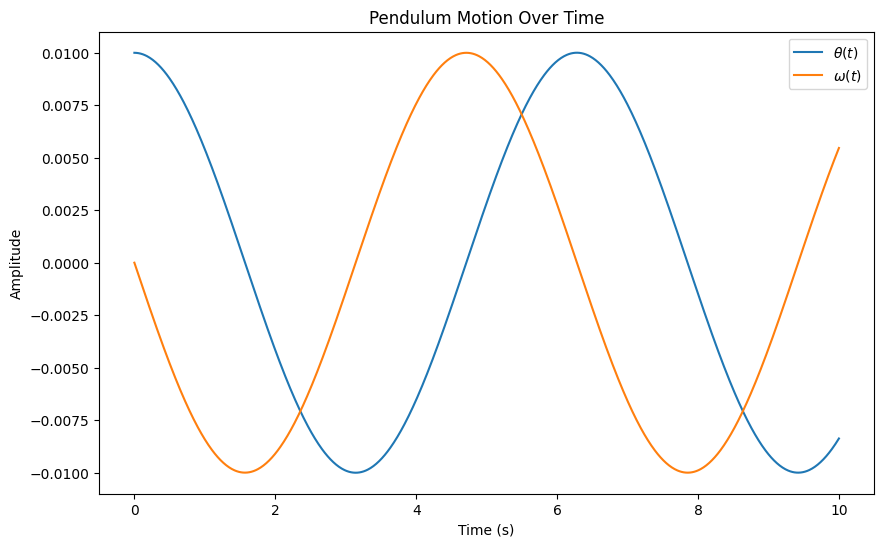

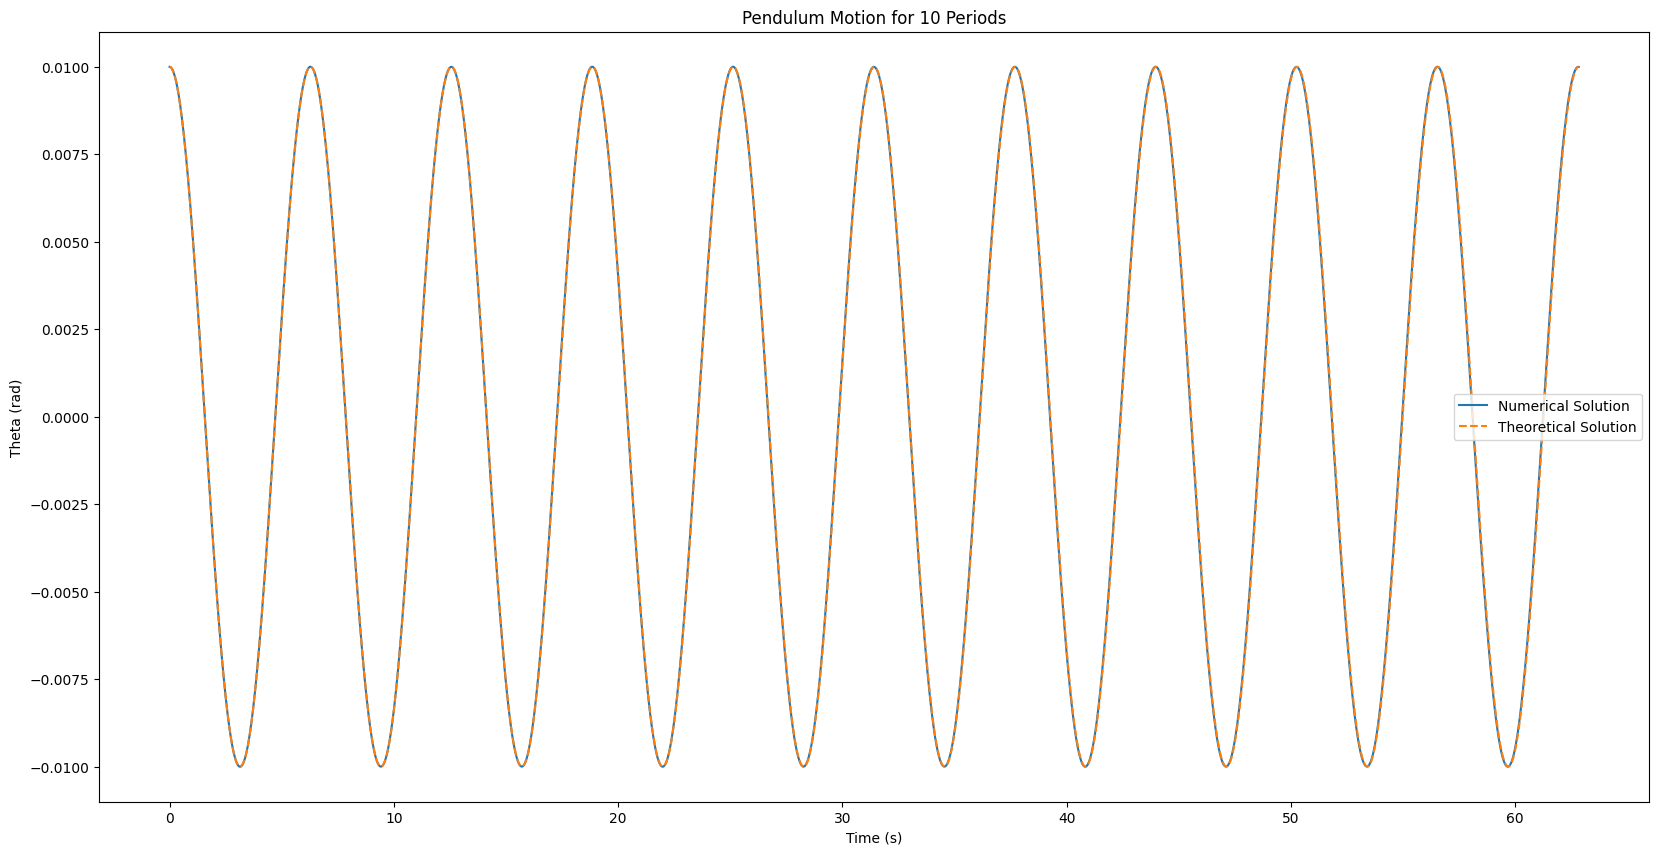

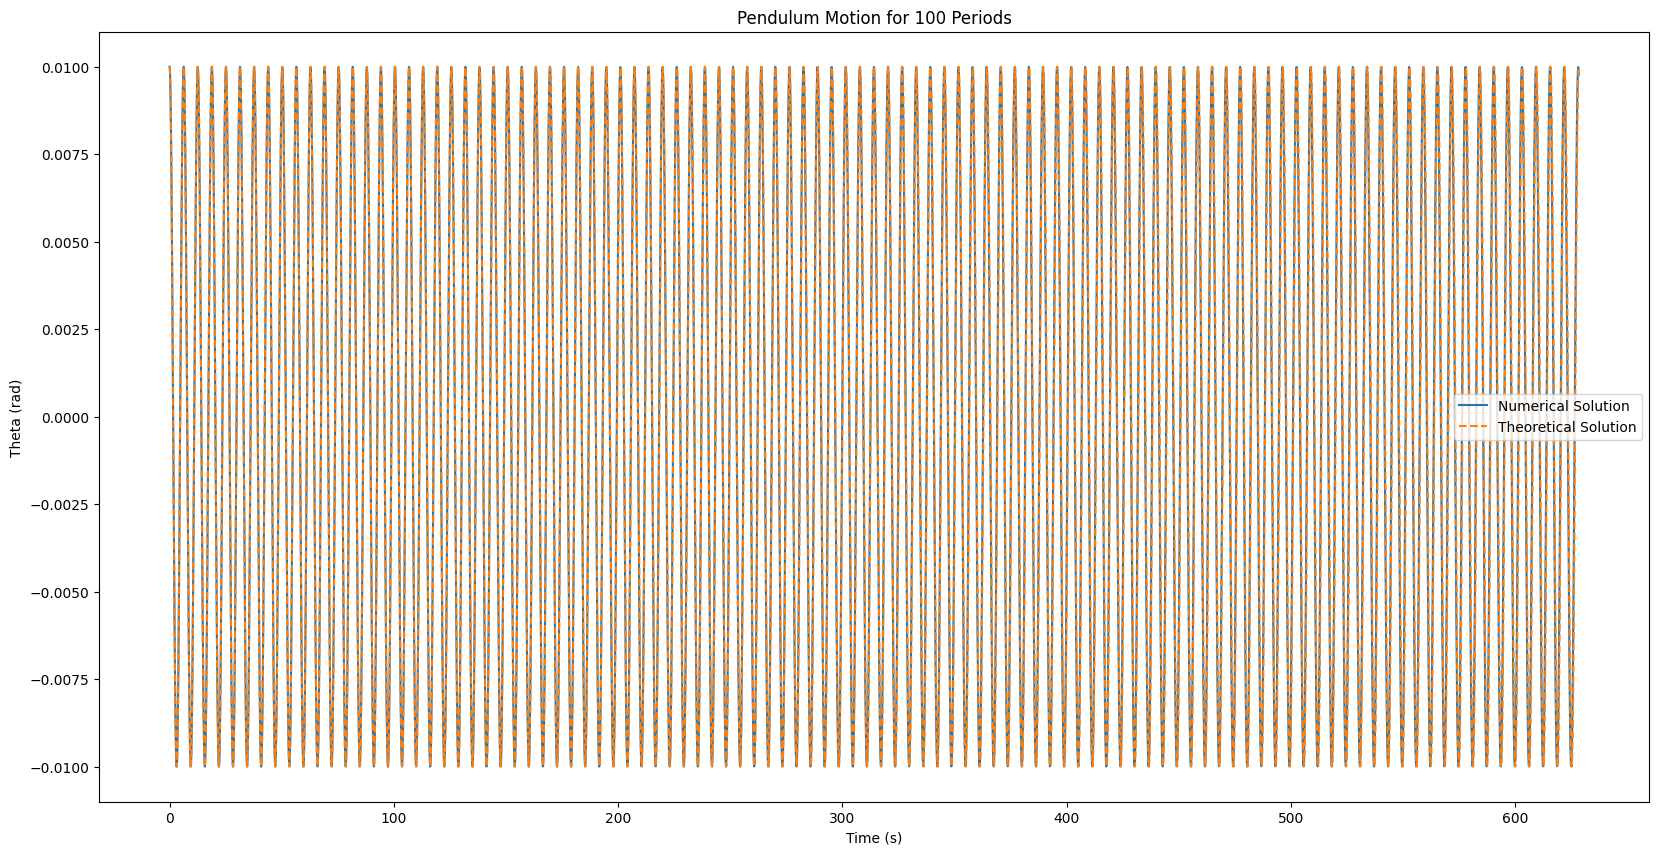

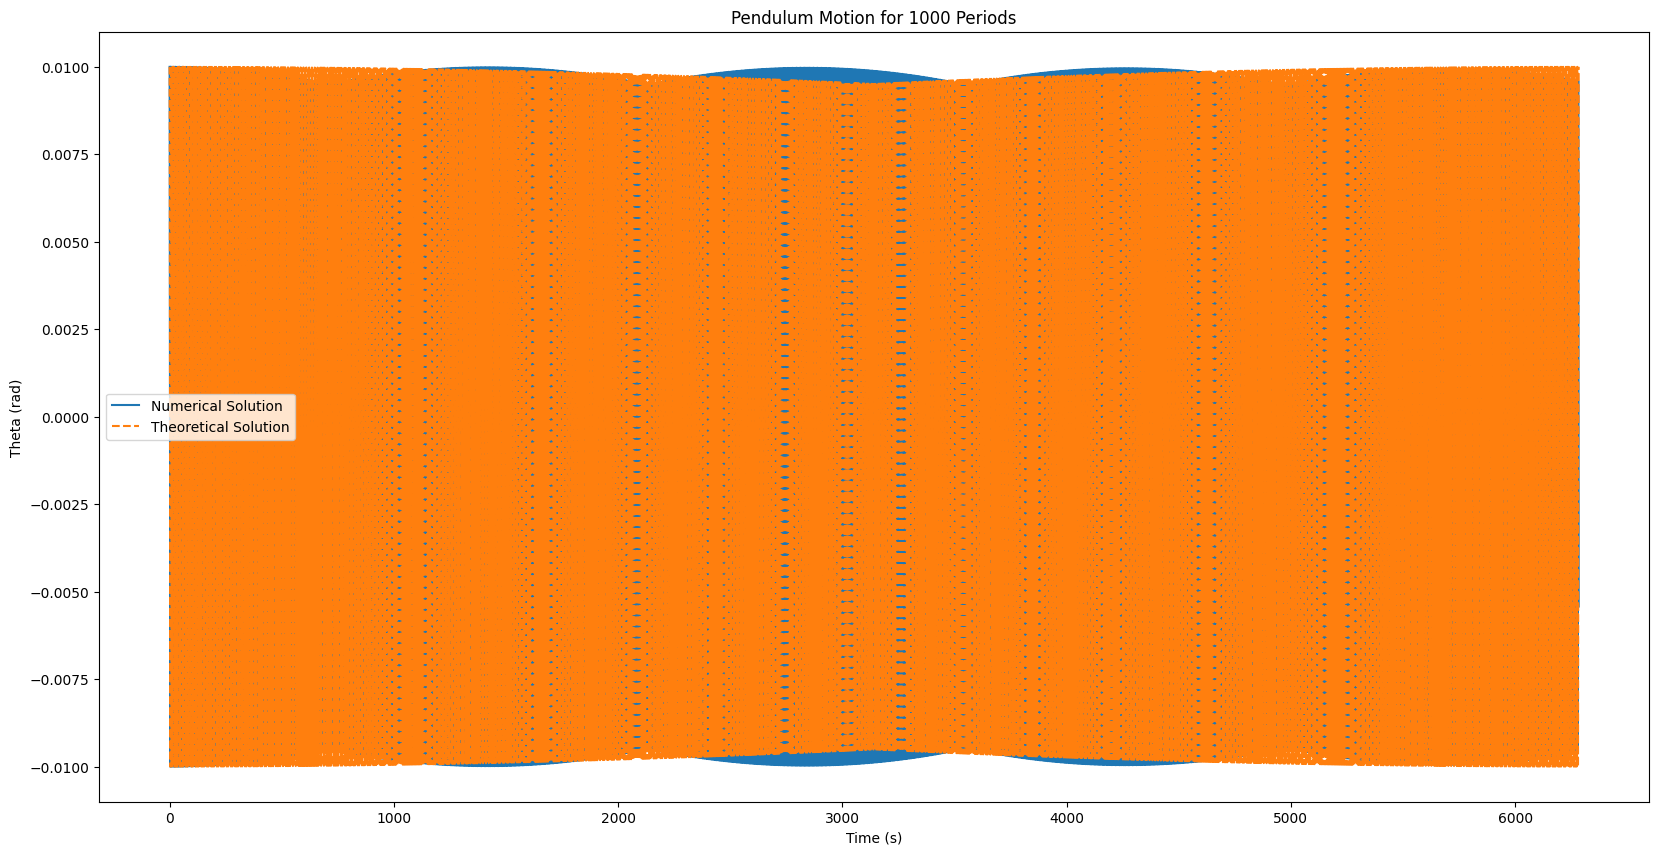

In [52]:
# Parameters
g = 9.81
l = g  # (for l=g, the natural period is 2*pi)
Omega_D = 2/3  # Driving frequency

# Convert the 2nd-order ODE into 2x 1st-order ODEs
def pendulum_ode(t, y, q, F):
    y0, y1 = y  # y0 = theta, y1 = omega
    dy0dt = y1
    dy1dt = - (g / l) * np.sin(y0) - q * y1 + F * np.sin(Omega_D * t)
    return [dy0dt, dy1dt]

# Initial conditions
theta_0 = 0.01
omega_0 = 0
y_initial = [theta_0, omega_0]

t_span = [0, 10]  # Start and end times
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points at which to evaluate integral

# Damping & driving parameters
q = 0
F = 0

# Solve the ODE
solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, F), t_eval=t_eval, method='RK45')

plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label=r'$\theta(t)$')
plt.plot(solution.t, solution.y[1], label=r'$\omega(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Pendulum Motion Over Time')
plt.legend()
plt.show()

# Small angle solution
def theoretical_solution(t, theta_0):
    return theta_0 * np.cos(t)

# Natural period, given that l=g
T_natural = 2 * np.pi

# Plot results for different numbers of periods
for periods in [10, 100, 1000]:
    t_span = [0, periods * T_natural]
    t_eval = np.linspace(t_span[0], t_span[1], 10000)

    solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, F), t_eval=t_eval)

    plt.figure(figsize=(20, 10))
    plt.plot(solution.t, solution.y[0], label='Numerical Solution')
    plt.plot(solution.t, theoretical_solution(solution.t, theta_0), '--', label='Theoretical Solution')
    plt.xlabel('Time (s)')
    plt.ylabel('Theta (rad)')
    plt.title(f'Pendulum Motion for {periods} Periods')
    plt.legend()
    plt.show()


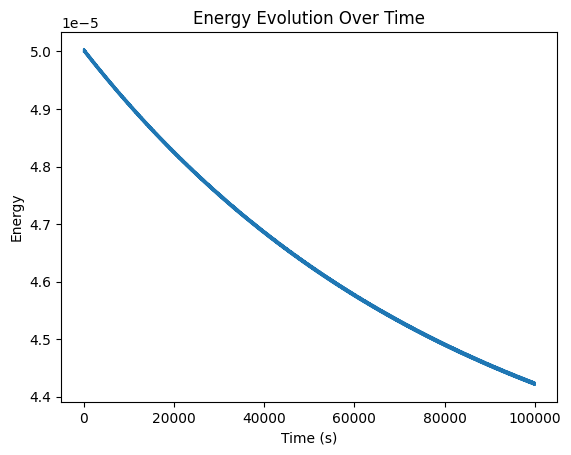

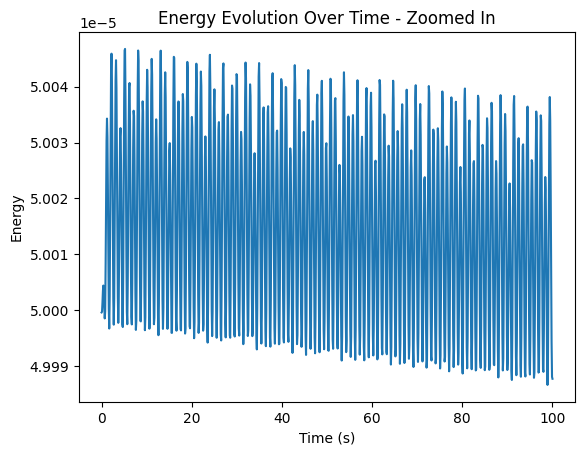

In [53]:
t_span = [0, 1e5]
t_eval = np.linspace(t_span[0], t_span[1], 10000)
solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, F), t_eval=t_eval, method='RK45')

# Kinetic + potential energy function
def total_energy(theta, omega):
    return 0.5 * omega**2 + (1 - np.cos(theta))

# Calculate energy & then plot against time
E = total_energy(solution.y[0], solution.y[1])
plt.plot(solution.t, E)

plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Evolution Over Time')
plt.show()

t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, F), t_eval=t_eval, method='RK45')
E = total_energy(solution.y[0], solution.y[1])
plt.plot(solution.t, E)

plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Evolution Over Time - Zoomed In')
plt.show()

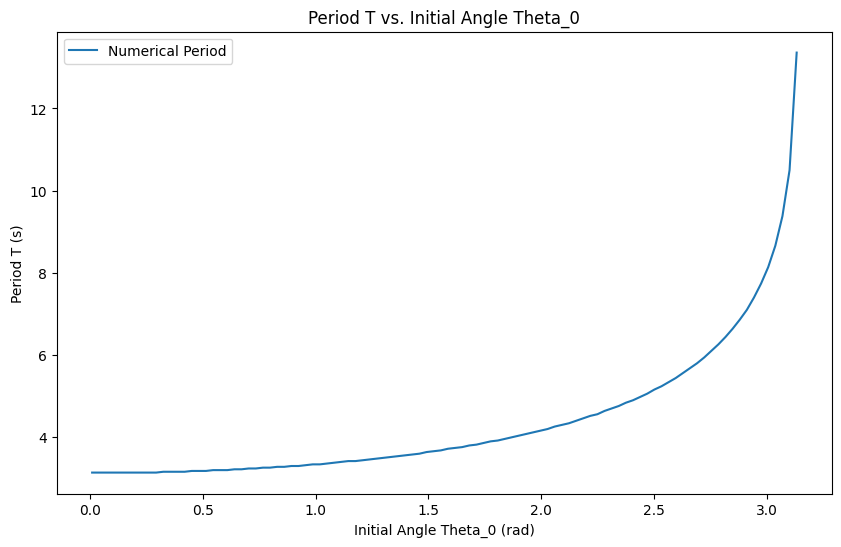

Period for theta_0 = pi/2 :3.7


In [54]:
def estimate_period(theta_0, dt=0.01, max_time=100):
    y_initial = [theta_0, 0]  # Start pendulum from rest
    t_span = [0, max_time]
    t_eval = np.arange(t_span[0], t_span[1], dt)

    solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, F), t_eval=t_eval, method='RK45')
    theta = solution.y[0]

    # Find the first zero-crossing to estimate the period
    for i in range(1, len(theta) - 1):
        if theta[i-1] > 0 and theta[i+1] < 0: # Crossing conditions
            return 2 * solution.t[i]  # Period is double the first crossing time

# Range of initial angles theta_0 from 0 to pi (slight offset to avoid divergence)
theta_0_values = np.linspace(0.01, np.pi - 0.01, 100)
periods = [estimate_period(theta_0) for theta_0 in theta_0_values]

plt.figure(figsize=(10, 6))
plt.plot(theta_0_values, periods, label='Numerical Period')
plt.xlabel('Initial Angle Theta_0 (rad)')
plt.ylabel('Period T (s)')
plt.title('Period T vs. Initial Angle Theta_0')
plt.legend()
plt.show()
print('Period for theta_0 = pi/2 :' + str(estimate_period(np.pi/2)))

***CORE TASK 1: CONCLUSIONS***

*1. Free, undamped pendulum behaviour*
- In the small angle approximation, our integrated solution agrees very closely with the theoretical prediction.
- We see, however, in the 1000 periods plot, the numerical solution becomes slightly out of phase with the theoretical solutions. Hence, it is important to remember than both solutions are approximations, albeit very good ones.

*2. Conservation of energy*
- Despite no damping, over very large timescales, the energy decays (from 5.0 to 4.5 over a span of 80 000s).
- This is likely due to numerical dissipation inherent to the numerical method used (RK45). Small numerical errors accumulate.
- Zooming in, the decay is oscillatory (faster than the pendulum's oscillations).
- The adaptive mechanisms in RK45 that control for error might inadvertently introduce feedback loops where the correction for one error slightly overshoots, necessitating a correction in the opposite direction in subsequent steps.

*3. Amplitude plot*
- Amplitude increases from its value at theta_0 = 0, and increases asymptotically at theta_0 = pi.
- This increase aligns with the theoretical expectation outside of the small-angle region.
- Our method for calculating the amplitude might be expected to break down at large angles, but seems to perform well until theta_0 = pi.
- Period for theta_0 = pi/2  is 3.7s.

**CORE TASK 2**

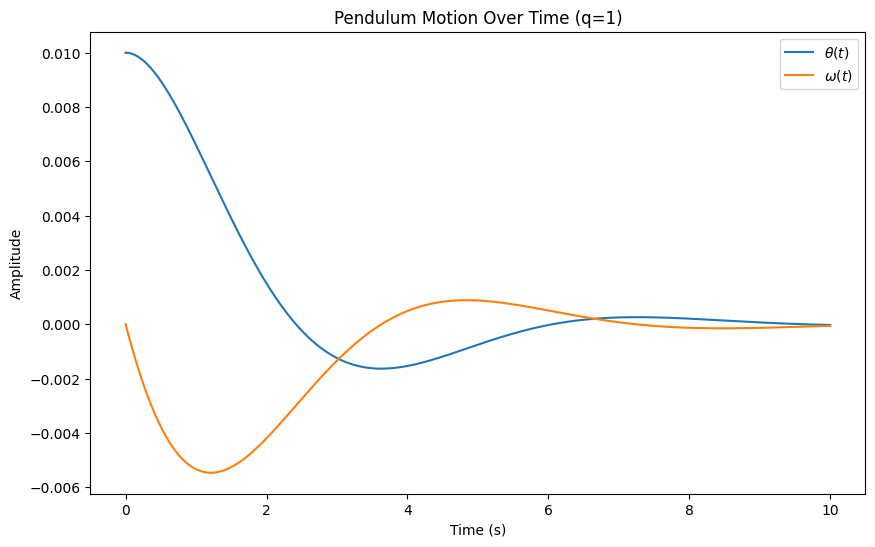

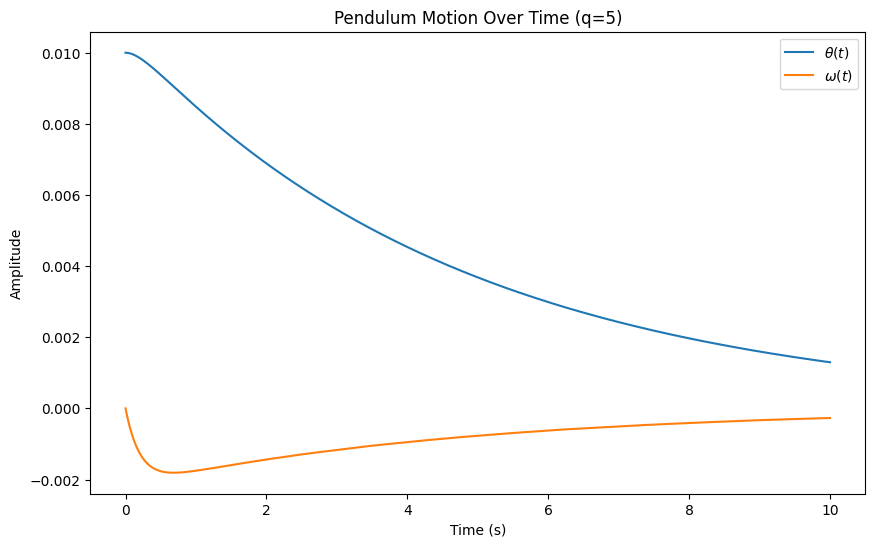

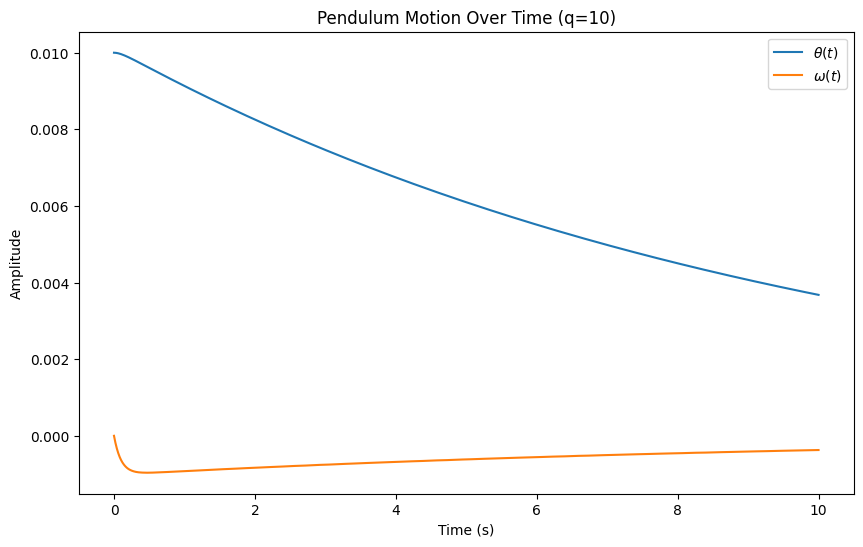

In [55]:
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Vary the damping coefficient
F = 0
for i in [1,5,10]:
  solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(i, F), t_eval=t_eval, method='RK45')

  plt.figure(figsize=(10, 6))
  plt.plot(solution.t, solution.y[0], label=r'$\theta(t)$')
  plt.plot(solution.t, solution.y[1], label=r'$\omega(t)$')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(f'Pendulum Motion Over Time (q={i})')
  plt.legend()
  plt.show()

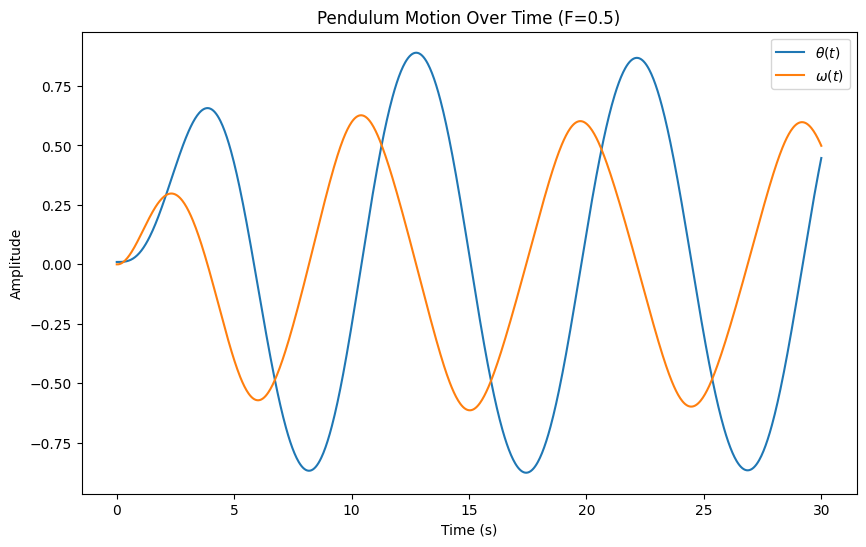

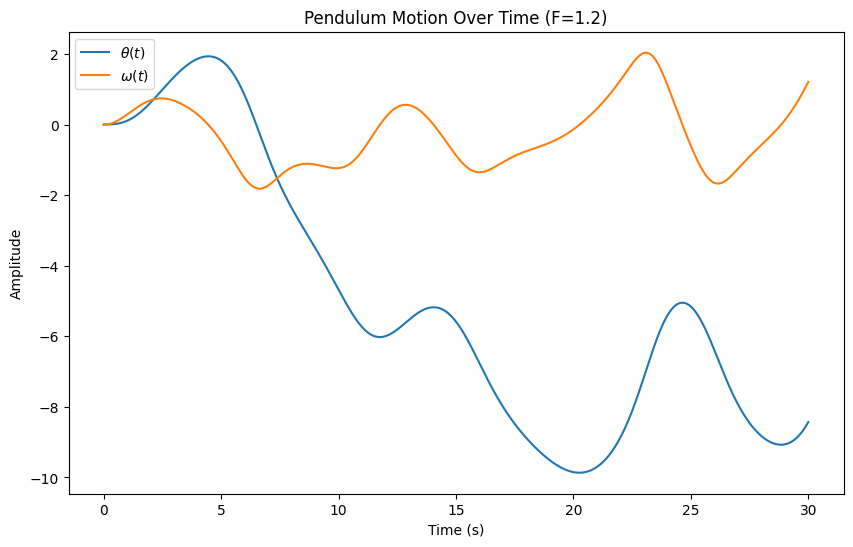

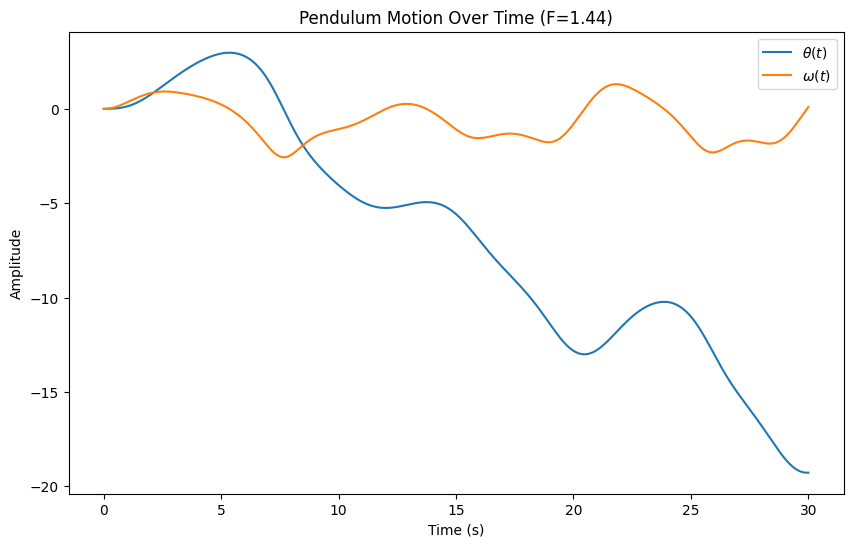

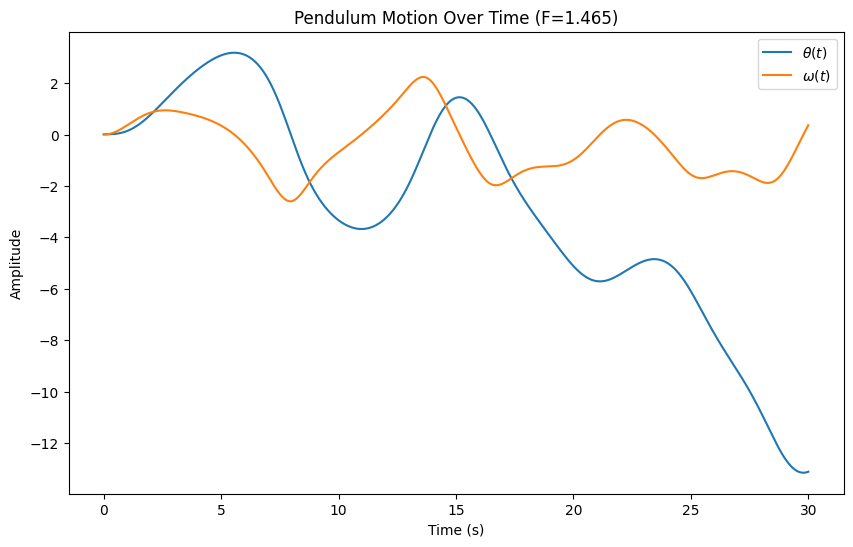

In [56]:
q=0.5
t_span = [0, 30]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
# Vary the driving force amplitude

for i in [0.5, 1.2, 1.44, 1.465]:
  solution = solve_ivp(pendulum_ode, t_span, y_initial, args=(q, i), t_eval=t_eval, method='RK45')

  plt.figure(figsize=(10, 6))
  plt.plot(solution.t, solution.y[0], label=r'$\theta(t)$')
  plt.plot(solution.t, solution.y[1], label=r'$\omega(t)$')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(f'Pendulum Motion Over Time (F={i})')
  plt.legend()
  plt.show()

***CORE TASK 2: CONCLUSIONS***
1. Varying damping
The range of q values exmpres three regions of damping:
- Light Damping: Oscillations gradually decrease in amplitude over time.
- Critical Damping: The pendulum returns to rest the fastest without oscillating.
- Heavy Damping: The pendulum slowly returns to rest without oscillating, slower than in critical damping.

2. Varying driving
- Motion is irregular with irregularity increasing with F
- When the driving force doesn't match the pendulum's natural frequency, the motion appears irregular due to increased external energy inputs.
- These inputs can push the system into non-linear regimes where the response becomes chaotic

- Amplitude increases with F
- The external force injects more energy into the system, sustaining larger oscillations.

**SUPPLEMENTARY TASK 1:**

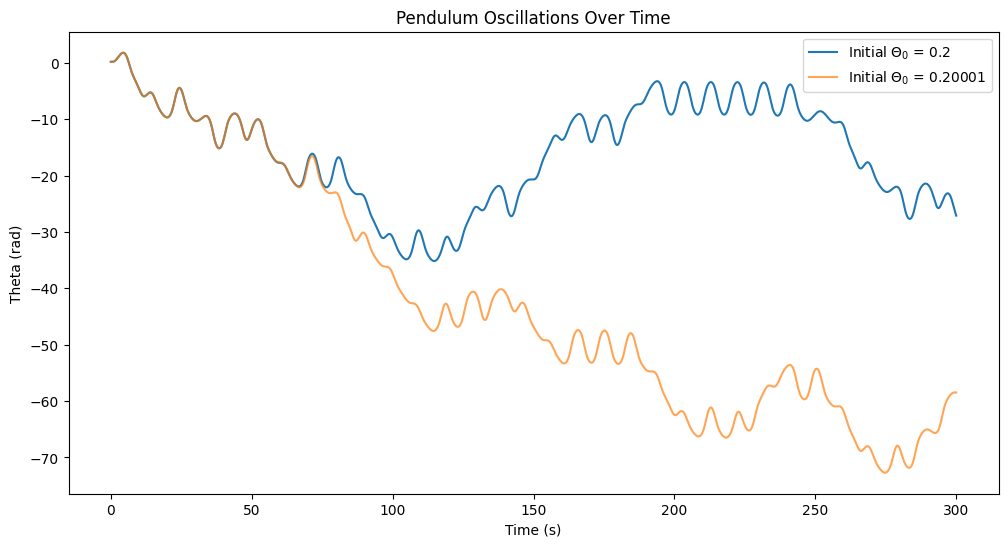

In [57]:
F = 1.2
A = 2/3
q = 0.5

t_span = (0, 300)  # Integrating for a 'long time'
t_eval = np.linspace(*t_span, 10000)

# Two very similar, but different initial conditions
y_initial_1 = (0.2, 0.0)
y_initial_2 = (0.20001, 0.0)


solution_set1 = solve_ivp(pendulum_ode, t_span, y_initial_1, args=(q, F), t_eval=t_eval, method='RK45')
solution_set2 = solve_ivp(pendulum_ode, t_span, y_initial_2, args=(q, F), t_eval=t_eval, method='RK45')

plt.figure(figsize=(12, 6))
plt.plot(solution_set1.t, solution_set1.y[0], label='Initial $\Theta_0$ = 0.2')
plt.plot(solution_set2.t, solution_set2.y[0], label='Initial $\Theta_0$ = 0.20001', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Pendulum Oscillations Over Time')
plt.legend()
plt.show()

***SUPPLEMENTARY TASK 1: CONCLUSIONS***
- The behaviour is initially the same, but begins to diverge at around 80s.
- This demonstrates high sensitivity to initial condtions (i.e. chaotic behaviour).
- Non-linear systems such as this are often highly chaotic, particulary when driven from equilibrium.
- The damping and driving terms contribute to this sensitivity.

**SUPPLEMENTARY TASK 2:**

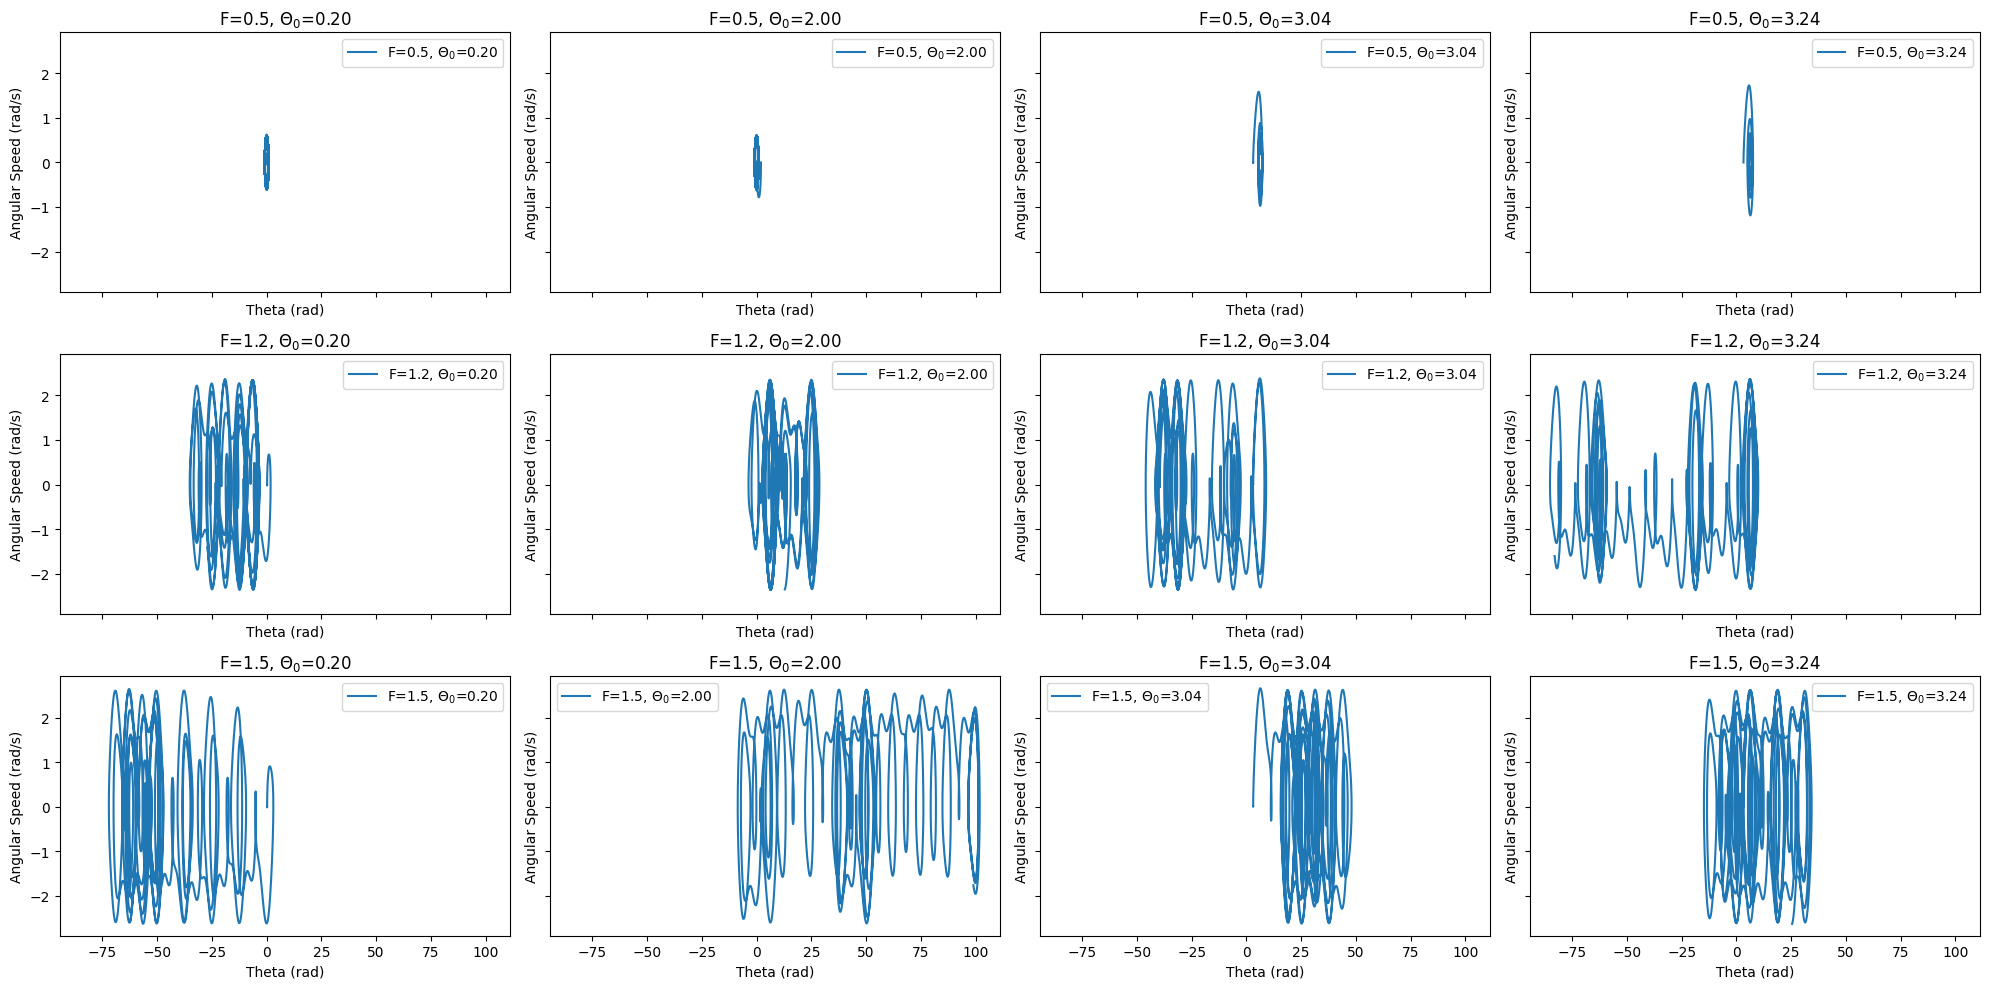

In [58]:
A = 2/3
q = 0.5

initial_conditions = [
    (0.2, 0),  # Small amplitude, similar to previous but for comparison
    (2.0, 0),  # Larger amplitude
    (np.pi - 0.1, 0),  # Near the unstable equilibrium
    (np.pi + 0.1, 0),  # Beyond the unstable equilibrium
]

F_values = [0.5, 1.2, 1.5]  # Different driving force amplitudes to explore various regimes

solutions = []
for F in F_values:
    for theta0, theta_dot0 in initial_conditions:
        sol = solve_ivp(pendulum_ode, t_span, [theta0, theta_dot0], args=(q, F), t_eval=t_eval, method='RK45')
        solutions.append((F, theta0, sol))

# Plotting angle vs. angular speed for various solutions
fig, axs = plt.subplots(len(F_values), len(initial_conditions), figsize=(20, 10), sharex=True, sharey=True)

for i, (F, theta0, sol) in enumerate(solutions):
    row = i // len(initial_conditions)
    col = i % len(initial_conditions)
    axs[row, col].plot(sol.y[0], sol.y[1], label=f'F={F}, $\Theta_0$={theta0:.2f}')
    axs[row, col].set_title(f'F={F}, $\Theta_0$={theta0:.2f}')
    axs[row, col].set_xlabel('Theta (rad)')
    axs[row, col].set_ylabel('Angular Speed (rad/s)')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

***SUPPLEMENTARY TASK 2: CONCLUSIONS***

Our phase space plots show various looping behaviours. On these Poincare maps, closed small loops indicate regular behviour, and larger, diffuse, random loops indicate chaotic behaviour.

F = 0.5: Tight, regular loops indicating stable, periodic oscillations with minimal energy input leading to predictable behavior.

Increasing F (1.2, 1.5): Larger, more complex loops, reflecting increased energy input and moving the system towards chaotic behavior.

Near & Beyond Unstable Equilibrium (π−0.1,π+0.1): Sensitive dependence on initial conditions, with slight deviations leading to significantly different outcomes, showing the system's instability at this point. Erratic trajectories displayed.
